# **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Kulinda Shamba: Wildlife Detection System for Farm Protection.**

**Project Overview:**

The Kulinda Shamba system, which translates from Swahili as **"Protect the Farm,"** is a smart AI-powered wildlife intrusion detection system developed to mitigate human wildlife conflict affecting smallholder farmers in Kenya.

This initiative uses transfer learning and image classification to detect specific animals elephants, monkeys, and buffaloes that are responsible for frequent crop damage in regions bordering protected wildlife reserves such as the Maasai Mara.

- The goal is to equip small farms with affordable, intelligent monitoring systems that can:

- Detect wildlife intrusions in real-time using Convolutional Neural Networks (CNN),

- Notify farmers via SMS or mobile alerts,

- Trigger non-lethal deterrents like LED flashers or buzzing sounds.

This system is built for low-bandwidth and off-grid rural environments, enabling communities to improve food security while promoting peaceful human-wildlife coexistence.

# **Import Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# **Dataset Overview**

## 1**. Data Collection:**

To build a reliable model capable of identifying target wildlife species, data was gathered from the following publicly available datasets on Kaggle:
### ***🐵 Monkey Dataset***
 [Monkey Dataset-Kaggle:](https://www.kaggle.com/datasets/slothkong/10-monkey-species)

This dataset contains thousands of labeled monkey images across 10 species. For this project, images specifically of Macaca mulatta and other related species were selected to build the "Monkey" class.

### ***🐘 Elephant and Other Animal Dataset:***
[Animal Classification Dataset - Kaggle](https://www.kaggle.com/datasets/ayushv322/animal-classification):

This dataset includes various animal categories such as elephants, buffaloes, lions, etc. The elephant and buffalo categories were extracted to create distinct "Elephant" and "Buffalo" classes.


###***🐾Unknown Dataset***
The unknown dataset consists of a diverse collection of images that were not part of the original training set. These include various animals, natural backgrounds, environmental scenes, and other unrelated visual content. The purpose of this dataset is to test the model's ability to handle out-of-distribution (OOD) inputs and evaluate how it performs when encountering unfamiliar or irrelevant data.

This dataset plays a crucial role in assessing the model’s:

- **Robustness** to unpredictable inputs

- **Generalization** beyond the known classes (Elephant, Monkey, Buffalo)

- **Confidence behavior**, especially in the presence of unrelated or noisy visuals

# **Data Loading**
The data collected from Kaggle was placed into a working directory named Kulinda, with separate folders for each class:

Each folder contains a balanced set of images (approximately 3000 per class and 700 images were called per class for training because of low computing power). The images were then:

- Renamed uniformly to avoid conflicts,

- Resized to 150x150 pixels (matching the model input size)

In [2]:
IMG_SIZE = 150
dataset_dir = '/content/drive/MyDrive/Kulinda'
categories = ['Elephant', 'Monkey', 'Buffalo', 'Unknown']


# **Preprocess Dataset**
These steps load and preprocess images from four categories:
- Elephant
- Monkey
- Buffalo.
- Unknown

**For each category, it performs the following steps:**

- Limits the number of images to 700 per class to ensure class balance and reduce memory usage.

- Reads each image, converts it from BGR to RGB format, resizes it to a uniform size (IMG_SIZE x IMG_SIZE), and normalizes pixel values to the [0, 1] range.

- Assigns a numeric label to each image based on its category.

- Appends the image and its label as a pair to the data list.

- Skips corrupted or unreadable images, printing a warning message when encountered.

In [ ]:
data = []
max_images_per_class = 700

for category in categories:
    path = os.path.join(dataset_dir, category)
    label = categories.index(category)

    count = 0
    for img in os.listdir(path):
        if count >= max_images_per_class:
            break

        try:
            img_path = os.path.join(path, img)
            img_arr = cv2.imread(img_path)
            img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
            img_arr = img_arr / 255.0
            data.append([img_arr, label])
            count += 1
        except Exception as e:
            print(f"Skipped {img_path}: {e}")



# **Shuffling and Splitting Dataset**
These steps prepares the dataset for model training by:

- Shuffling the data to ensure a random mix of classes, avoiding any learning bias due to file order.

- Separating features (X) from labels (y):

- X contains the image data (pixel arrays).

- y contains the corresponding numeric class labels (0 for Elephant, 1 for Monkey, 2 for Buffalo).

In [ ]:
# Shuffling the data and Splitting into feature matrix (X) and target vector (y)
random.shuffle(data)
X = []
y = []
for feature, label in data:
    X.append(feature)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)


# **Visualize Preprocessed Images**
Displaying samples images from each class after preprocessing to confirm that the images were correctly:

- Resized to the desired input shape,

- Normalized to pixel values between 0 and 1,

- Labeled accurately according to the defined categories.

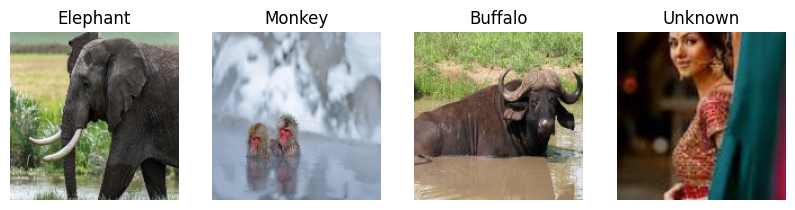

In [ ]:
# visuaize the preprocessed images

plt.figure(figsize=(10, 10))
for i in range(len(categories)):
    # Find the first occurrence of each class in the shuffled data
    idx = np.where(y == i)[0][0]
    plt.subplot(1, len(categories), i + 1)
    plt.imshow(X[idx])
    plt.title(categories[i])
    plt.axis('off')
plt.show()

# **One-Hot Encoding & Train/Test Split**
This steps prepares the labels and splits the dataset into training and testing sets.

In [ ]:
from tensorflow.keras.utils import to_categorical

y_categorical = to_categorical(y, num_classes=4)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.25, stratify=y, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Training samples: 2100
Testing samples: 700


# **Data augmentation**
This steps increases training data variety using random transformations (rotation, shift, zoom, flip), helping the model generalize better and avoid overfitting.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


# **Visualize Class Distribution**
Creating a bar chart to show how many images belong to each class in the training set, helping confirm that the dataset is balanced across Elephant, Monkey, and Buffalo.

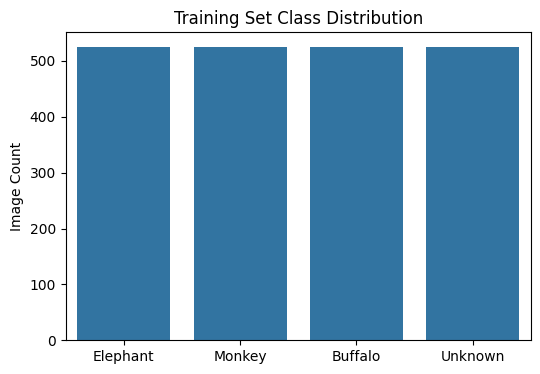

In [ ]:
class_counts = np.sum(y_train, axis=0)
plt.figure(figsize=(6, 4))
sns.barplot(x=categories, y=class_counts)
plt.title("Training Set Class Distribution")
plt.ylabel("Image Count")
plt.show()


# **Build CNN Model**

The model defined here is a Convolutional Neural Network (CNN) designed for multi-class image classification, specifically targeting 4 classes (as indicated by the final Dense(4, activation='softmax') layer).

## **🧱 Architecture Overview**
This CNN follows a deep feature extraction and classification pipeline, composed of:

1. **Convolutional Layers (Conv2D)**

- Extracts hierarchical spatial features (edges, textures, shapes)

- Filters increase in depth: 128 → 64 → 32 to gradually reduce complexity

**2. Activation Function: ReLU**

- Introduces non-linearity, allowing the model to learn complex patterns

**3. Max Pooling Layers (MaxPooling2D)**

- Downsamples the feature maps

- Reduces spatial dimensions while retaining key features

**4. Dropout Layers**

- Randomly disables a fraction of neurons during training (here 30%)

- Prevents overfitting and improves generalization

**5. Flatten**

- Converts the 2D feature maps into a 1D vector for the dense layers

**6. Fully Connected Dense Layers** **bold text**

- Dense(32): Learns high-level combinations of features

- Dense(4, softmax): Outputs a probability distribution over 4 classes



In [ ]:
model_vanilla = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model_vanilla.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_vanilla.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9248)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       295,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 391,940 (1.50 MB)

 Trainable params: 391,940 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

# **Train Model**

The model is trained for 50 epochs with a batch size of 32 using the training data, while the validation set is used to monitor performance. A ModelCheckpoint is used to automatically save the model (model2.h5) whenever it achieves the highest validation accuracy during training. This ensures that the best-performing version of the model is preserved for later use.

In [ ]:
checkpoint_vanilla = ModelCheckpoint('model2.h5', save_best_only=True, monitor='val_accuracy', mode='max')

history_vanilla = model_vanilla.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[checkpoint_vanilla]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.2941 - loss: 1.3849

66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.2947 - loss: 1.3844 - val_accuracy: 0.4457 - val_loss: 1.2047
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4465 - loss: 1.2018

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.4467 - loss: 1.2014 - val_accuracy: 0.5157 - val_loss: 1.1381
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5185 - loss: 1.1207

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.5184 - loss: 1.1207 - val_accuracy: 0.5671 - val_loss: 1.1102
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.5287 - loss: 1.0918 - val_accuracy: 0.5557 - val_loss: 1.0809
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.5441 - loss: 1.0521 - val_accuracy: 0.5500 - val_loss: 1.0533
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5591 - loss: 1.0707

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.5591 - loss: 1.0706 - val_accuracy: 0.6043 - val_loss: 1.0243
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.5933 - loss: 0.9705 - val_accuracy: 0.5829 - val_loss: 1.0377
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6147 - loss: 0.9789

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.6146 - loss: 0.9789 - val_accuracy: 0.6100 - val_loss: 0.9820
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.6226 - loss: 0.9258 - val_accuracy: 0.6071 - val_loss: 0.9550
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6242 - loss: 0.9163

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6242 - loss: 0.9163 - val_accuracy: 0.6414 - val_loss: 0.9138
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.6566 - loss: 0.8797 - val_accuracy: 0.6229 - val_loss: 0.9347
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6407 - loss: 0.8574 - val_accuracy: 0.6271 - val_loss: 0.9072
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6721 - loss: 0.8119

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6720 - loss: 0.8120 - val_accuracy: 0.6486 - val_loss: 0.8519
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6969 - loss: 0.7924

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.6967 - loss: 0.7926 - val_accuracy: 0.6514 - val_loss: 0.8833
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6899 - loss: 0.7400

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6899 - loss: 0.7403 - val_accuracy: 0.6557 - val_loss: 0.8627
Epoch 16/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6847 - loss: 0.7900

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6848 - loss: 0.7899 - val_accuracy: 0.6757 - val_loss: 0.8200
Epoch 17/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.6958 - loss: 0.7445 - val_accuracy: 0.6600 - val_loss: 0.8113
Epoch 18/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7252 - loss: 0.6958

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7250 - loss: 0.6961 - val_accuracy: 0.6943 - val_loss: 0.8134
Epoch 19/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7137 - loss: 0.7163

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.7138 - loss: 0.7163 - val_accuracy: 0.7186 - val_loss: 0.7525
Epoch 20/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7463 - loss: 0.6664 - val_accuracy: 0.7171 - val_loss: 0.7742
Epoch 21/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7330 - loss: 0.6863 - val_accuracy: 0.7043 - val_loss: 0.7611
Epoch 22/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7439 - loss: 0.6206 - val_accuracy: 0.7057 - val_loss: 0.7251
Epoch 23/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7508 - loss: 0.6208

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7506 - loss: 0.6213 - val_accuracy: 0.7314 - val_loss: 0.7112
Epoch 24/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7458 - loss: 0.6365 - val_accuracy: 0.7086 - val_loss: 0.7361
Epoch 25/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7655 - loss: 0.6194

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.7655 - loss: 0.6194 - val_accuracy: 0.7529 - val_loss: 0.6931
Epoch 26/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7566 - loss: 0.6306 - val_accuracy: 0.7486 - val_loss: 0.6821
Epoch 27/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7502 - loss: 0.6192 - val_accuracy: 0.7286 - val_loss: 0.6922
Epoch 28/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7547 - loss: 0.5955 - val_accuracy: 0.7371 - val_loss: 0.6953
Epoch 29/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7513 - loss: 0.5957

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7514 - loss: 0.5957 - val_accuracy: 0.7586 - val_loss: 0.6631
Epoch 30/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7832 - loss: 0.5963 - val_accuracy: 0.7243 - val_loss: 0.6749
Epoch 31/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7858 - loss: 0.5479 - val_accuracy: 0.7586 - val_loss: 0.6664
Epoch 32/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.7803 - loss: 0.5675 - val_accuracy: 0.7471 - val_loss: 0.6409
Epoch 33/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7840 - loss: 0.5555 - val_accuracy: 0.7357 - val_loss: 0.6547
Epoch 34/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7840 - loss: 0.5589

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.7839 - loss: 0.5591 - val_accuracy: 0.7714 - val_loss: 0.6219
Epoch 35/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7724 - loss: 0.5433

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.7723 - loss: 0.5435 - val_accuracy: 0.7829 - val_loss: 0.6083
Epoch 36/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7900 - loss: 0.5281 - val_accuracy: 0.7543 - val_loss: 0.6353
Epoch 37/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.7971 - loss: 0.5271 - val_accuracy: 0.7229 - val_loss: 0.7014
Epoch 38/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.7913 - loss: 0.5272 - val_accuracy: 0.7529 - val_loss: 0.6297
Epoch 39/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7997 - loss: 0.5384 - val_accuracy: 0.7457 - val_loss: 0.6446
Epoch 40/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.7951 - loss: 0.5153 - val_accuracy: 0.7471 - val_loss: 0.6527
Epoch 41/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.7784 - loss: 0.5417 - val_accuracy: 0.7471 - val_loss: 0.6500
Epoch 42/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.7868 - loss: 0.5269 - val_accuracy

66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.8245 - loss: 0.4662 - val_accuracy: 0.7886 - val_loss: 0.5949
Epoch 47/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.7949 - loss: 0.4934 - val_accuracy: 0.7543 - val_loss: 0.6420
Epoch 48/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.8338 - loss: 0.4272 - val_accuracy: 0.7671 - val_loss: 0.6544
Epoch 49/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.8031 - loss: 0.4931 - val_accuracy: 0.7657 - val_loss: 0.6162
Epoch 50/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.8124 - loss: 0.4669 - val_accuracy: 0.7700 - val_loss: 0.6060


# **Plot Accuracy & Loss**

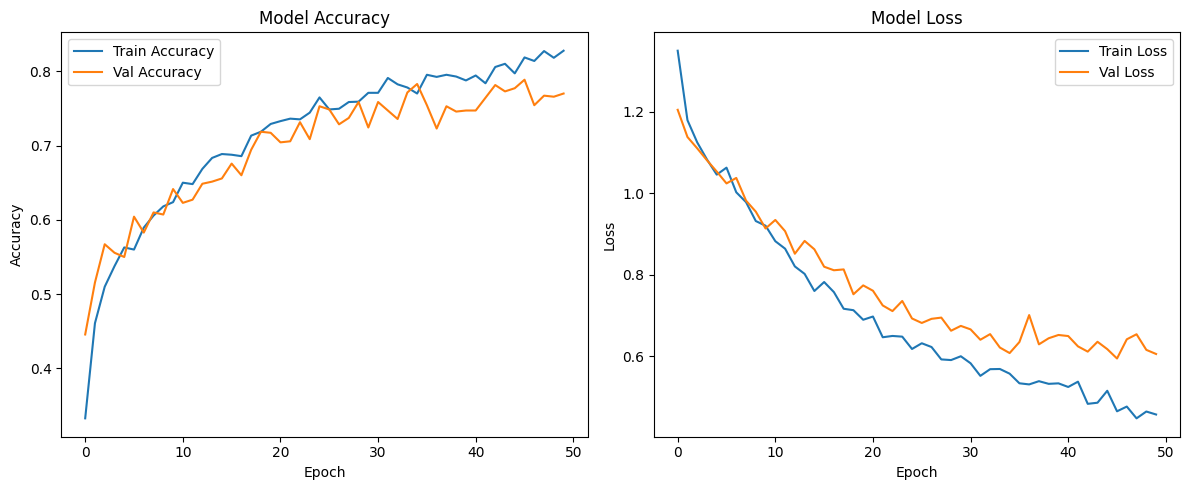

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_vanilla.history['accuracy'], label='Train Accuracy')
plt.plot(history_vanilla.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vanilla.history['loss'], label='Train Loss')
plt.plot(history_vanilla.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Explanation of the above graphs**
###***📈 Training Performance Summary***
The plots above show the model's training and validation performance over 50 epochs.

- **Model Accuracy (left):** Both training and validation accuracy consistently improve, indicating that the model is learning well.

 The training accuracy reaches ~**85**%, while the validation accuracy stabilizes around ~**77**%, showing good generalization.

- **Model Loss (right):** Both training and validation loss decrease steadily, with training loss dropping lower than validation loss.

 This is typical and suggests the model is fitting the data well without severe overfitting.

✅ **Overall, the model shows strong learning performance and maintains a healthy gap between training and validation metrics, which means it generalizes well to unseen data.**



# **Evaluate Performance and Confusion Matrix**

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


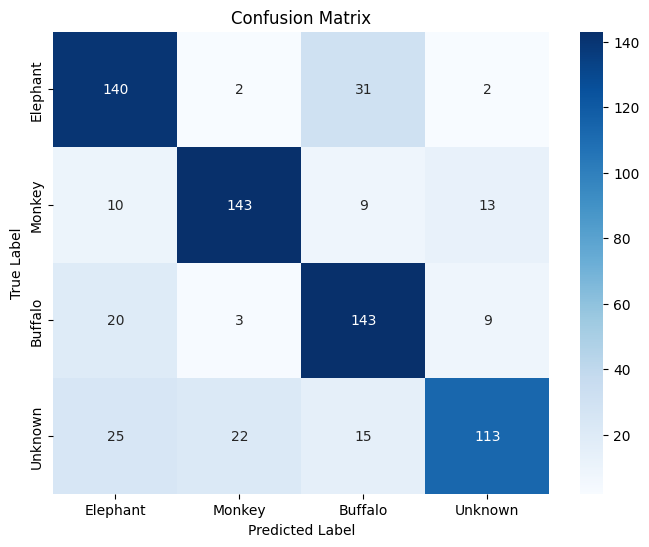

Classification Report:
              precision    recall  f1-score   support

    Elephant       0.72      0.80      0.76       175
      Monkey       0.84      0.82      0.83       175
     Buffalo       0.72      0.82      0.77       175
     Unknown       0.82      0.65      0.72       175

    accuracy                           0.77       700
   macro avg       0.78      0.77      0.77       700
weighted avg       0.78      0.77      0.77       700



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test set
y_pred_probs = model_vanilla.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

## **📊 Model Evaluation Summary**
The confusion matrix and classification report provide a detailed evaluation of the model's performance across the four classes: Elephant, Monkey, Buffalo, and Unknown.

## **✅ Key Insights:**
- Diagonal values (e.g., 140, 143, 143, 113) represent correct predictions. These are relatively high, indicating strong class-wise performance.

- The **Unknown** class was predicted correctly 113 times, but also confused with Elephant, Monkey, and Buffalo — indicating some room for improvement in detecting out-of-distribution data.

- **Elephant** has slightly lower precision (0.72) and recall (0.80), meaning it's sometimes misclassified as Buffalo or Unknown.

- **Monkey** shows the best performance overall, with the highest F1-score (0.83).

- Overall accuracy: 78%, which is solid for a 4-class classification task with an Unknown class.



# **Image Upload + Prediction**

Saving DSC_11281_1500.jpg to DSC_11281_1500 (4).jpg
Saving monkey-2449893_1280.jpg to monkey-2449893_1280 (3).jpg
Saving 1s803ne5x2_elephantv2.jpg to 1s803ne5x2_elephantv2 (2).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step

File: DSC_11281_1500 (4).jpg
Prediction: Buffalo
Confidence: 98.32%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

File: monkey-2449893_1280 (3).jpg
Prediction: Monkey
Confidence: 94.93%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

File: 1s803ne5x2_elephantv2 (2).jpg
Prediction: Elephant
Confidence: 97.58%


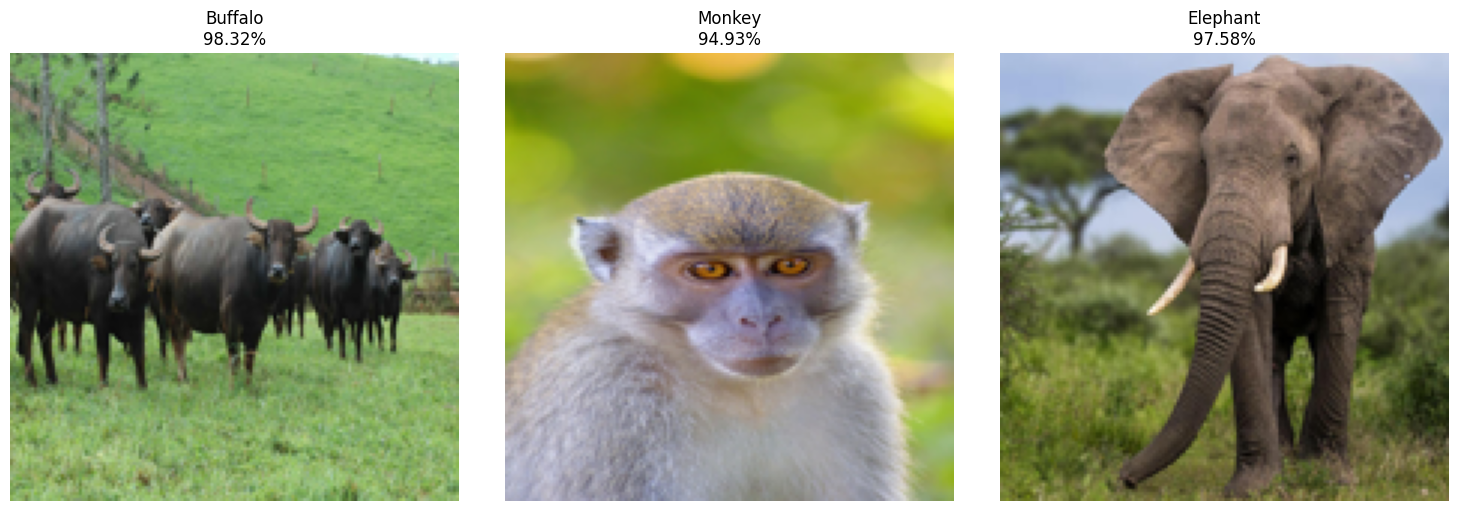

In [7]:
#let us test the prediction by uploading multiple images and displaying each horizontally with results underneath

from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io

# === Setup ===
IMG_SIZE = 150
categories = ['Elephant', 'Monkey', 'Buffalo']  # Replace with your actual class names

# Load the model
try:
    model_predict = load_model('model2.h5')
except Exception as e:
    print(f"Error loading model: {e}")
    model_predict = None

# Proceed only if model loaded
if model_predict:
    uploaded = files.upload()

    images = []
    predictions_text = []

    for filename in uploaded.keys():
        try:
            # Preprocess image
            img = Image.open(io.BytesIO(uploaded[filename])).convert('RGB')
            img_resized = img.resize((IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img_resized) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predict
            preds = model_predict.predict(img_array)
            class_index = np.argmax(preds)
            label = categories[class_index]
            confidence = preds[0][class_index] * 100

            # Store for display
            images.append(img_resized)
            predictions_text.append(f"{label}\n{confidence:.2f}%")

            # Console print (optional)
            print(f"\nFile: {filename}")
            print(f"Prediction: {label}")
            print(f"Confidence: {confidence:.2f}%")

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    # === Display all images horizontally with labels underneath ===
    n = len(images)
    if n > 0:
        fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
        if n == 1:
            axes = [axes]  # wrap single axis for consistency

        for i in range(n):
            axes[i].imshow(images[i])
            axes[i].axis('off')
            axes[i].set_title(predictions_text[i], fontsize=12)

        plt.tight_layout()
        plt.show()

else:
    print("Model not loaded. Cannot perform predictions.")


# ***The End***

